# Weight Decay

In [1]:
import sys
sys.path.append('../..')

In [2]:
%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## High-dimensional Linear Regression

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01)$$

In [3]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

## Weight Decay from Scratch

### Initialize Model Parameters

In [4]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

### Define Squared $\ell_2$ Norm Penalty

In [5]:
def l2_penalty(w):
    return (w**2).sum() / 2

### Define Training and Testing

In [6]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train_features, train_labels), batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                # The L2 norm penalty term has been added.
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        evaluate = lambda X, y: loss(net(X, w, b), y).mean().asscalar()
        train_ls.append(evaluate(train_features, train_labels))
        test_ls.append(evaluate(test_features, test_labels))
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                range(1, num_epochs + 1), test_ls, ['train', 'test'], [8, 4])
    print('l2 norm of w:', w.norm().asscalar())

### Training without Regularization

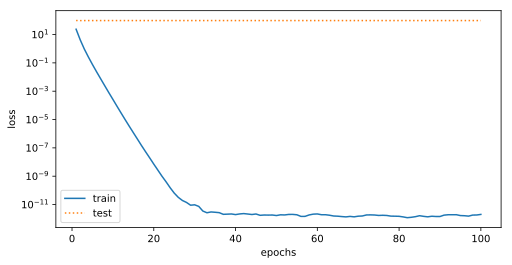

l2 norm of w: 13.15568


In [7]:
fit_and_plot(lambd=0)

### Using Weight Decay

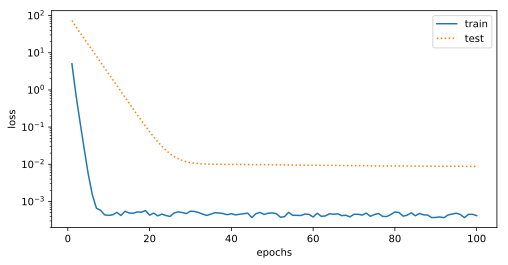

l2 norm of w: 0.042428378


In [8]:
fit_and_plot(lambd=3)

## Weight Decay in Gluon

In [9]:
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # The weight parameter has been decayed. Weight names generally end with "weight".
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',
                              {'learning_rate': lr, 'wd': wd})
    # The bias parameter has not decayed. Bias names generally end with "bias".
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                              {'learning_rate': lr})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # Call the step function on each of the two Trainer instances to update the weight and bias separately.
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        evaluate = lambda X, y: loss(net(X), y).mean().asscalar()
        train_ls.append(evaluate(train_features, train_labels))
        test_ls.append(evaluate(test_features, test_labels))
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                range(1, num_epochs + 1), test_ls, ['train', 'test'], [8, 4])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

### Using Weight Decay

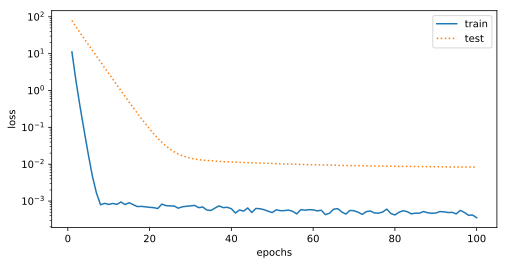

L2 norm of w: 0.04438015


In [12]:
fit_and_plot_gluon(wd=3)

### Training without Regularization

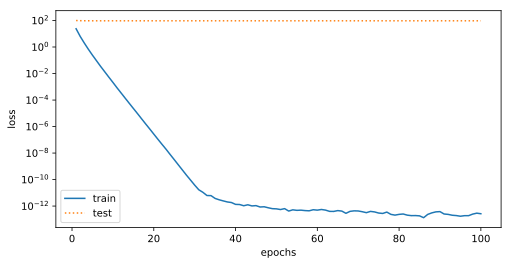

L2 norm of w: 12.641677


In [13]:
fit_and_plot_gluon(wd=0)